In [2]:
import sys
if '../Toolkit' not in sys.path: sys.path.append('../Toolkit')

%load_ext autoreload
%autoreload 1

%aimport tools
%aimport models

import tools as t
import models as m

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.display import clear_output

import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 999
pd.options.display.max_rows = 113
import matplotlib.pyplot as plt
import seaborn as sns

RS = 35577 # global random state seed
raw_data_path = 'data-raw'
processed_data_path = 'data-processed'

In [79]:
import time
from collections import OrderedDict
def adv_sequential_feature_selection(X, y, score_func, base_features = [], num_features_to_select = -1, verbose= 0, on_feature_selected=None):
    """
    Custom implementation of Sequential Feature Selection that allowes to select starting/base features, 
    prints the progress of finding features and allowes to pick up selecting features where you left off.

    :param X: train df with features
    :param y: train df with target
    :param score_func: function that will be called with X, and y. Should return score in form of 1 float - this si your function with CV or test/train split
    :param base_features: list of features to always include in scoring
    :param num_features_to_select: number of featrues to select from (X.columns - base_features). Will start from best and finish when limit is reached
    :param verbose: logging levels 1 - log when best featre is found, 2 - log every sequence trained
    :param on_feature_selected: function that accepts a series with detailed resultsm of all feature scores for current best feature
    :return: series with best features
    """
    
    base_features = sorted(list(base_features))
    features_to_select_from = sorted(list(set(X.columns) - set(base_features)))
    if verbose > 1:
        print(f'features_to_select_from: {features_to_select_from}')
        print(f'base_features: {base_features}')
    
    if num_features_to_select == -1:
        num_features_to_select = len(features_to_select_from)
    
    scorred_features = OrderedDict()
    pending_features_to_score = []
    
    # df_verb_2_log = pd.DataFrame(index=features_to_select_from)
    
    for i in range(num_features_to_select):
        scores = {}
        for feature in features_to_select_from:
            features_to_fit = base_features + list(scorred_features.keys()) + [feature]
            
            fit_start_time = time.perf_counter()
            score = score_func( X[features_to_fit], y)
            fit_time_elapsed = np.round((time.perf_counter() - fit_start_time)/1000, 1)
            
            if verbose > 1:
                # print(f'Base: {base_features}   Selected: {list(scorred_features.keys())}   Added: {feature}   Score {score}   Time: {fit_time_elapsed}s')
                print(f'   [{features_to_fit}]   Score {np.round(score,4)}   Time: {fit_time_elapsed}s')
            scores[feature] = score
        
        best_feature = max(scores, key=scores.get)
        best_score = scores[best_feature]
        if verbose > 0:
            print(f'Best feature: {best_feature}   Score: {best_score}\n')
        
        if not (on_feature_selected is None):
            scores_for_current_feature = pd.Series(scores)
            scores_for_current_feature.name = best_feature
            on_feature_selected(scores_for_current_feature)
        
        scorred_features[best_feature] = best_score
        features_to_select_from.remove(best_feature)

    return pd.Series(scorred_features)

In [62]:
top_15_fetures = ['x__skew',
 'z__sum',
 'z__skew',
 'xyz__amin',
 'y__sum',
 'x__sum',
 'x__kurtosis',
 'y__skew',
 'z__p99',
 'x__p30',
 'x__p70',
 'z__mean',
 'x__median',
 'xyz__kurtosis',
 'y__p70']

top_30_fetures = ['x__skew',
 'z__sum',
 'z__skew',
 'xyz__amin',
 'y__sum',
 'x__sum',
 'x__kurtosis',
 'y__skew',
 'z__p99',
 'x__p30',
 'x__p70',
 'z__mean',
 'x__median',
 'xyz__kurtosis',
 'y__p70',
 'x__amax',
 'z__kurtosis',
 'z__amax',
 'x__mean',
 'y__mean',
 'z__p10',
 'y__amin',
 'z__p70',
 'y__p30',
 'y__median',
 'z__amin',
 'y__kurtosis',
 'x__amin',
 'y__p90',
 'z__median']

In [87]:
(X, y) = t.from_pkl(f'{processed_data_path}/all_b1_b2_xyz_distance_cluster1.data.pkl')

X = X[top_15_fetures]
# X = X[top_30_fetures]

X.shape
X.columns

y.shape
y.value_counts()

(200, 15)

Index(['x__skew', 'z__sum', 'z__skew', 'xyz__amin', 'y__sum', 'x__sum',
       'x__kurtosis', 'y__skew', 'z__p99', 'x__p30', 'x__p70', 'z__mean',
       'x__median', 'xyz__kurtosis', 'y__p70'],
      dtype='object')

(200,)

0    100
1    100
Name: status, dtype: int64

In [88]:
from sklearn.preprocessing import scale, power_transform
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

from sklearn.metrics import adjusted_rand_score

%aimport transformations

# Top 15 Features

In [89]:
df_data = X
df_data['status'] = y
df_data.head(3)
df_data.shape

,x__skew,z__sum,z__skew,xyz__amin,y__sum,x__sum,x__kurtosis,y__skew,z__p99,x__p30,x__p70,z__mean,x__median,xyz__kurtosis,y__p70,status
0,0.565319,5642.467250,-0.239643,0.101637,-1121.855887,5575.268706,-0.192928,1.177432,6.134114,-1.979711,1.702056,0.140598,-0.563647,1.778544,0.771121,0
1,0.064638,5708.853653,0.193339,0.183889,-1591.550244,-6971.401465,0.337405,0.809109,7.927740,-2.074116,1.702056,0.178062,-0.186030,1.633724,1.347793,0
2,0.118662,4560.664303,0.100333,0.044074,-1257.606062,-6932.965833,0.350866,0.478897,8.027385,-1.979711,1.513248,0.133862,-0.280434,1.956811,1.732240,0


(200, 16)

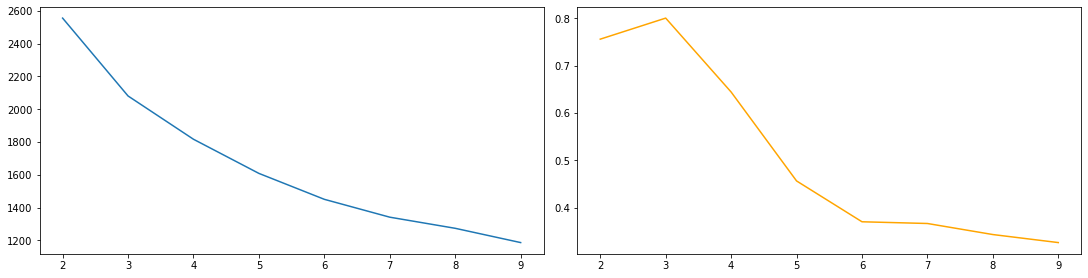

In [90]:
n_clusters = list(range(2, 10))
    
inertias = []
clusters = []
scores = []

for n in n_clusters:
    model = KMeans(n_clusters=n, random_state=RS)
    lbls = model.fit_predict(scale(X))
    
    scores.append(adjusted_rand_score(lbls, y))

    inertias.append(model.inertia_)
    clusters.append(n)
    
axs = t.get_axes(1, 2, 0.5).flat
_ = axs[0].plot(clusters, inertias)
_ = axs[1].plot(clusters, scores, c='orange')


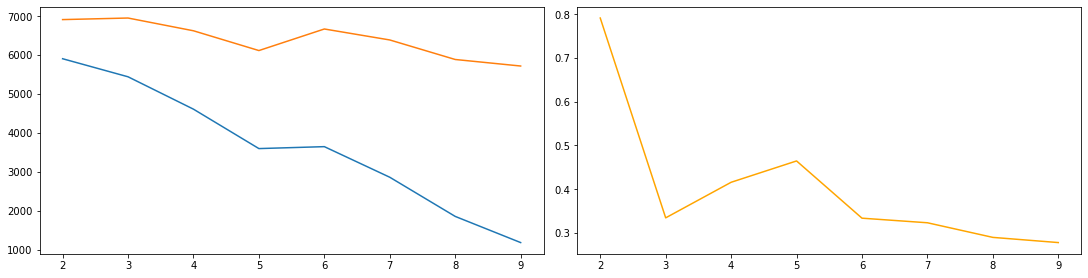

In [92]:
n_clusters = list(range(2, 10))
    
aics = []
bics = []
clusters = []
scores = []

for n in n_clusters:
    model = GaussianMixture(n_components=n, random_state=RS)
    X_ = power_transform(X)
    lbls = model.fit_predict(X_)
    
    scores.append(adjusted_rand_score(lbls, y))

    aics.append(model.aic(X_))
    bics.append(model.bic(X_))
    clusters.append(n)
    
axs = t.get_axes(1, 2, 0.5).flat
_ = axs[0].plot(clusters, aics)
_ = axs[0].plot(clusters, bics)
_ = axs[1].plot(clusters, scores, c='orange')


# Select Features

In [96]:
(X, y) = t.from_pkl(f'{processed_data_path}/all_b1_b2_xyz_distance_cluster1.data.pkl')

X.shape
X.columns

y.shape
y.value_counts()

(200, 72)

Index(['x__amin', 'x__amax', 'x__sum', 'x__median', 'x__mean', 'x__std',
       'x__var', 'x__p01', 'x__p10', 'x__p20', 'x__p30', 'x__p99', 'x__p90',
       'x__p80', 'x__p70', 'x__iqr', 'x__kurtosis', 'x__skew', 'y__amin',
       'y__amax', 'y__sum', 'y__median', 'y__mean', 'y__std', 'y__var',
       'y__p01', 'y__p10', 'y__p20', 'y__p30', 'y__p99', 'y__p90', 'y__p80',
       'y__p70', 'y__iqr', 'y__kurtosis', 'y__skew', 'z__amin', 'z__amax',
       'z__sum', 'z__median', 'z__mean', 'z__std', 'z__var', 'z__p01',
       'z__p10', 'z__p20', 'z__p30', 'z__p99', 'z__p90', 'z__p80', 'z__p70',
       'z__iqr', 'z__kurtosis', 'z__skew', 'xyz__amin', 'xyz__amax',
       'xyz__sum', 'xyz__median', 'xyz__mean', 'xyz__std', 'xyz__var',
       'xyz__p01', 'xyz__p10', 'xyz__p20', 'xyz__p30', 'xyz__p99', 'xyz__p90',
       'xyz__p80', 'xyz__p70', 'xyz__iqr', 'xyz__kurtosis', 'xyz__skew'],
      dtype='object')

(200,)

0    100
1    100
Name: status, dtype: int64

In [97]:
def score_func(X, y):
    model = KMeans(n_clusters=2, random_state=RS)
    lbls = model.fit_predict(scale(X))
    
    return adjusted_rand_score(lbls, y)

adv_sequential_feature_selection(X, y, score_func, num_features_to_select=15, verbose=1)

Best feature: z__p99   Score: 0.299461634859534

Best feature: x__kurtosis   Score: 0.4067907517813

Best feature: y__p70   Score: 0.4597383289330955

Best feature: x__skew   Score: 0.5016379915047655

Best feature: z__skew   Score: 0.5754743853142064

Best feature: xyz__amin   Score: 0.6707560967726296

Best feature: z__kurtosis   Score: 0.7211020062877994

Best feature: y__mean   Score: 0.6873365255102273

Best feature: y__kurtosis   Score: 0.6064254026230091

Best feature: x__p30   Score: 0.6381935129369556

Best feature: z__mean   Score: 0.6543716847411352

Best feature: xyz__kurtosis   Score: 0.6064420988838948

Best feature: y__p80   Score: 0.6222062852741759

Best feature: y__skew   Score: 0.6381818181818182

Best feature: xyz__skew   Score: 0.5016017474526837



z__p99           0.299462
x__kurtosis      0.406791
y__p70           0.459738
x__skew          0.501638
z__skew          0.575474
xyz__amin        0.670756
z__kurtosis      0.721102
y__mean          0.687337
y__kurtosis      0.606425
x__p30           0.638194
z__mean          0.654372
xyz__kurtosis    0.606442
y__p80           0.622206
y__skew          0.638182
xyz__skew        0.501602
dtype: float64

In [98]:
def score_func(X, y):
    model = KMeans(n_clusters=3, random_state=RS)
    lbls = model.fit_predict(scale(X))
    
    return adjusted_rand_score(lbls, y)

adv_sequential_feature_selection(X, y, score_func, num_features_to_select=15, verbose=1)

Best feature: x__mean   Score: 0.31207353869336524

Best feature: xyz__p70   Score: 0.43474111238894436

Best feature: x__kurtosis   Score: 0.4655931897549119

Best feature: z__skew   Score: 0.5521090531858746

Best feature: z__p99   Score: 0.5735393071260549

Best feature: x__p30   Score: 0.5883582819902577

Best feature: y__p70   Score: 0.5845956755373981

Best feature: x__skew   Score: 0.5625484517439594

Best feature: x__p20   Score: 0.5776305828343253

Best feature: x__median   Score: 0.5993894400537236

Best feature: z__iqr   Score: 0.5957691901204577

Best feature: z__p80   Score: 0.5663602246758035

Best feature: xyz__amin   Score: 0.5552435010992712

Best feature: x__sum   Score: 0.5481838812924126

Best feature: x__std   Score: 0.581066187251133



x__mean        0.312074
xyz__p70       0.434741
x__kurtosis    0.465593
z__skew        0.552109
z__p99         0.573539
x__p30         0.588358
y__p70         0.584596
x__skew        0.562548
x__p20         0.577631
x__median      0.599389
z__iqr         0.595769
z__p80         0.566360
xyz__amin      0.555244
x__sum         0.548184
x__std         0.581066
dtype: float64

In [99]:
def score_func(X, y):
    model = GaussianMixture(n_components=2, random_state=RS)
    X_ = power_transform(X)
    lbls = model.fit_predict(X_)
    
    return adjusted_rand_score(lbls, y)

adv_sequential_feature_selection(X, y, score_func, num_features_to_select=15, verbose=1)

Best feature: z__var   Score: 0.36904382584791356

Best feature: x__sum   Score: 0.5305468365298418

Best feature: x__kurtosis   Score: 0.6707481151667462

Best feature: x__amax   Score: 0.6873327356977816

Best feature: xyz__amin   Score: 0.6873327356977816

Best feature: z__p30   Score: 0.6707514408828931

Best feature: y__p90   Score: 0.6707620827230948

Best feature: x__median   Score: 0.7041280743396798

Best feature: y__kurtosis   Score: 0.7041280743396798

Best feature: x__amin   Score: 0.6873365255102273

Best feature: y__mean   Score: 0.6707780441936051

Best feature: x__p99   Score: 0.6873327356977816

Best feature: y__skew   Score: 0.6381883965746077

Best feature: z__mean   Score: 0.7041137290631736

Best feature: x__p01   Score: 0.6381847419414792



z__var         0.369044
x__sum         0.530547
x__kurtosis    0.670748
x__amax        0.687333
xyz__amin      0.687333
z__p30         0.670751
y__p90         0.670762
x__median      0.704128
y__kurtosis    0.704128
x__amin        0.687337
y__mean        0.670778
x__p99         0.687333
y__skew        0.638188
z__mean        0.704114
x__p01         0.638185
dtype: float64

# with 10 best from trees

In [104]:
def score_func(X, y):
    model = GaussianMixture(n_components=2, random_state=RS)
    X_ = power_transform(X)
    lbls = model.fit_predict(X_)
    
    return adjusted_rand_score(lbls, y)

adv_sequential_feature_selection(X, y, score_func, base_features = top_15_fetures[:10],  num_features_to_select=10, verbose=1)

Best feature: xyz__skew   Score: 0.6707461197048087

Best feature: z__mean   Score: 0.7041185109765681

Best feature: xyz__kurtosis   Score: 0.7211020062877994

Best feature: y__p90   Score: 0.7382933076910645

Best feature: y__kurtosis   Score: 0.755678268568101

Best feature: x__var   Score: 0.755678268568101

Best feature: y__mean   Score: 0.6543633058771182

Best feature: z__p80   Score: 0.41968913748553927

Best feature: xyz__sum   Score: 0.4462176340576289

Best feature: z__p30   Score: 0.4462646091019117



xyz__skew        0.670746
z__mean          0.704119
xyz__kurtosis    0.721102
y__p90           0.738293
y__kurtosis      0.755678
x__var           0.755678
y__mean          0.654363
z__p80           0.419689
xyz__sum         0.446218
z__p30           0.446265
dtype: float64